In [1]:
import pathlib
import numpy as np
import healpy as hp
import skyproj
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import astropy.coordinates
from astropy import units as u
from scipy import stats
import galstreams #contains stream data
%matplotlib inline

CURRENT_DIR = pathlib.Path.cwd().resolve()
DATA_DIR = CURRENT_DIR.parent / 'data'

## Functions

In [2]:
def change_coord(m, coord):   
    """ Change coordinates of a HEALPIX mapc

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

 # from https://stackoverflow.com/questions/44443498/how-to-convert-and-save-healpy-map-to-different-coordinate-systemb

In [106]:
import numpy as np
from scipy.spatial import cKDTree

def spread_clusters_kernel(points, radius, k=0.1, max_iter=100, tol=1e-6, min_repulsion=0.01):
    """
    DISCLAIMER: Made with DeepSeek, not properly tested, use at your own risk

    Spread apart points that are too close using a kernel-based approach.
    
    Parameters:
    -----------
    points : np.ndarray
        (N, 2) array of x,y coordinates
    radius : float
        Points within this distance are considered "too close"
    k : float
        Strength of the repulsion force (0.1 is a good starting value)
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance
    min_repulsion : float
        Minimum repulsion to apply (avoids numerical issues)
    
    Returns:
    --------
    np.ndarray: Adjusted points
    """
    points = points.copy().astype(float)
    n_points = len(points)
    
    # Build KD-tree for efficient nearest neighbor queries
    tree = cKDTree(points)
    
    for iteration in range(max_iter):
        max_displacement = 0
        new_points = points.copy()
        
        # For each point, find all neighbors within radius
        for i in range(n_points):
            # Query all points within radius (including self)
            indices = tree.query_ball_point(points[i], radius)
            
            if len(indices) <= 1:
                # Isolated point, skip
                continue
                
            # Get vectors from current point to all neighbors
            vectors = points[indices] - points[i]
            distances = np.linalg.norm(vectors, axis=1)
            
            # Remove self (distance = 0)
            mask = distances > 0
            vectors = vectors[mask]
            distances = distances[mask]
            
            if len(distances) == 0:
                continue
            
            # Calculate repulsion for each neighbor based on distance
            # Using an inverse square kernel: stronger repulsion for closer points
            repulsion_weights = k * (1.0 - distances / radius)**2
            
            # Also consider density: more neighbors = stronger overall repulsion
            density_factor = len(distances) / (np.pi * radius**2)
            repulsion_weights *= (1 + density_factor)
            
            # Ensure minimum repulsion
            repulsion_weights = np.maximum(repulsion_weights, min_repulsion)
            
            # Calculate displacement direction vectors (normalized)
            norm_vectors = vectors / distances[:, np.newaxis]
            
            # Sum repulsion vectors weighted by kernel
            displacement = np.sum(norm_vectors * repulsion_weights[:, np.newaxis], axis=0)
            
            # Apply displacement
            new_points[i] += displacement
            
            # Track maximum displacement for convergence check
            max_displacement = max(max_displacement, np.linalg.norm(displacement))
        
        # Update points
        points = new_points
        
        # Update KD-tree with new positions
        tree = cKDTree(points)
        
        # Check convergence
        if max_displacement < tol:
            break
    
    return points


In [110]:

def plot_galaxies(sp, gals=None, glist=None, annotate=False, glabels=None,radec = False, spread_scale = 4):
    """ plots all galaxies within 10 Mpc 
    (requires nbg.cat--- file with table of galaxies from Karachentsev et al)

    Parameters
    ----------
    sp : skyproj object
      map on which to plot the galaxies
    glist: list of integers
      list of indices for galaxies to label
      if None, plots the whole table
    glabels: list of strings
      labels for the galaxies
      if None, numbers them 1 to N
    Returns
    -------
    cbh : figure handle containing information needed to produce a colorbar 
    
    Example
    -------
    Plot all the galaxies on a predefined skyproj
    >>>> plot_galaxies(sp)
    """
    from matplotlib.colors import LogNorm
    import pandas as pd
    from astropy import units as u
    from astropy.coordinates import SkyCoord


    if gals is None:
    #read and process the table
        nbg, nbgs = read_galaxies()
        dists = nbg[' D (Mpc)']*u.Mpc
        norm = LogNorm(vmin=0.2,vmax=10)
        r = 80
    else:
        if 'RA J2000  ' in gals.keys():
            ras=[]
            decs=[]
            hms_str = ['h','m','s']
            dms_str = ['d','m','s']
            for i in range(len(gals)):
                ra_str=gals['RA J2000  '][i].split(' ')
                dec_str = gals['DEC J2000'][i].split(' ')
                ras.append("".join(x+y for x,y in zip(ra_str,hms_str)))
                decs.append("".join(x+y for x,y in zip(dec_str,dms_str)))
            nbgs=SkyCoord(ras,decs)
            dists = gals[' D (Mpc)']
            norm = LogNorm(vmin=0.2,vmax=10)
            r = 80
        else:
            nbgs=SkyCoord(gals['ra'].values*u.deg,gals['dec'].values*u.deg)
            dists = gals['distance'].values
            norm = LogNorm(vmin=15,vmax=350)
            r = 30
    #set up the colormap (log distance)
    cmap = plt.get_cmap('cividis')
    #norm = LogNorm() #(vmin=0.2,vmax=10.)

    #plot the galaxies
    if glist is None:
        if radec:
            cbh = sp.scatter(nbgs.ra.value, nbgs.dec.value, c=dists,  edgecolors= "black", cmap=cmap, norm=norm, s=40)
        else:
            cbh = sp.scatter(nbgs.galactic.l.value, nbgs.galactic.b.value, c=dists,  edgecolors= "black", cmap=cmap, norm=norm, s=40)
    else:
        if radec:
            cbh = sp.scatter(nbgs.ra.value[glist], nbgs.dec.value[glist], c=dists[glist],  edgecolors= "black", cmap=cmap, norm=norm, s=40)
        else:            
            cbh = sp.scatter(nbgs.galactic.l.value[glist], nbgs.galactic.b.value[glist], c=dists[glist],  edgecolors= "black", cmap=cmap, norm=norm, s=40)
        #label the ones listed
        if annotate:
            if glabels is None:
                glabels = np.arange(1, len(glist)+1).astype('str')
            xy_positions = []
            for i, l in enumerate(glabels):
                if radec:
                    x,y = sp.proj(nbgs[glist[i]].ra.deg, nbgs[glist[i]].dec.deg)
                else:
                    x,y = sp.proj(nbgs[glist[i]].galactic.l.deg, nbgs[glist[i]].galactic.b.deg)
                xy_positions.append([x[0],y[0]])
            xy_positions = np.array(xy_positions)
            xy_center = np.mean(xy_positions, axis=0)
            theta_pole = np.arctan2(*tuple((xy_positions-xy_center).T))
            theta = theta_pole+np.pi/2
            xyt_positions = (xy_positions.T + [r*np.cos(theta), r*np.sin(theta)]).T
            xyt_positions = [spread_scale,1]*spread_clusters_kernel(xyt_positions*[1/spread_scale,1], radius=10, k=10)
            xyt_positions -= xy_positions
            for i, l in enumerate(glabels):
                x,y = xy_positions[i]
                xt, yt = xyt_positions[i]
                sp.ax.annotate(l.strip(' '), (x,y), (xt,yt),textcoords='offset points',arrowprops=dict(arrowstyle='-',color='k'),va='top',ha='left', **(annotate if isinstance(annotate, dict) else {}))
                
    return cbh

In [108]:
def get_footprint(coords = 'G'):
    import healpy as hp
    # Read maps with the "tiles" covered -- these are built from APT's outputs
    HLWAS_wide = hp.read_map(DATA_DIR / 'HLWAS_WIDE_0328_APT994_1024.fits.gz')
    HLWAS_medium = hp.read_map(DATA_DIR / 'HLWAS_MEDIUM_0328_APT994_1024.fits.gz')
    maps = [HLWAS_wide, HLWAS_medium]
    
    #combine maps
    combined_map = np.zeros_like(HLWAS_wide)
    for i, m in enumerate(maps):
        m[m==hp.UNSEEN] = 0.
        combined_map[m!=0] = (i+1)*1.0

    combined_map[combined_map <=0] = hp.UNSEEN # Fill back with UNSEEN

    if coords=='G':
        combined_map = change_coord(combined_map,['C','G'])
    
    return combined_map


In [5]:
def read_satellites():
    import pandas as pd
    nbglm=pd.read_csv(DATA_DIR / 'Roman_MW_Dwarf_Targets.csv')
    return nbglm

In [6]:
def read_galaxies():
    """ reads list of all galaxies within 10 Mpc 
    (requires nbg.cat--- file with table of galaxies from Karachentsev et al)
      
    Returns
    -------
    nbg : pandas dataframe with table in it
    nbgs : list of skycoords for each galaxy 
    
    Example
    -------
    Plot all the galaxies on a predefined skyproj
    >>>> plot_galaxies(sp)
    """

    import pandas as pd
    #read and process the table
    nbg=pd.read_csv(DATA_DIR / 'nbg.cat',sep="|",usecols=range(1,13))
    ras=[]
    decs=[]
    hms_str = ['h','m','s']
    dms_str = ['d','m','s']
    for i in range(len(nbg)):
        ra_str=nbg['RA J2000  '][i].split(' ')
        dec_str = nbg['DEC J2000'][i].split(' ')
        ras.append("".join(x+y for x,y in zip(ra_str,hms_str)))
        decs.append("".join(x+y for x,y in zip(dec_str,dms_str)))
    nbgs= astropy.coordinates.SkyCoord(ras,decs)

    return nbg, nbgs

In [7]:
def select_satellites_in_footprint(fp,nbglm):
    nbglm_in_hlwas_north=[]
    nbglm_in_hlwas_south=[]
    for i in range(len(nbglm)):
        coord = astropy.coordinates.SkyCoord(nbglm['ra'][i]*u.deg,nbglm['dec'][i]*u.deg)
        ipix = hp.ang2pix(hp.get_nside(fp),coord.galactic.l.value, coord.galactic.b.value,lonlat=True)
        if not fp[ipix]==hp.UNSEEN:
            if coord.galactic.b.value > 0:
                nbglm_in_hlwas_north.append(i)
            else:
                nbglm_in_hlwas_south.append(i)
    print(len(nbglm_in_hlwas_north),'satellites in northern footprint')
    print(len(nbglm_in_hlwas_south),'satellites in southern footprint')    
    return nbglm_in_hlwas_north, nbglm_in_hlwas_south

In [102]:
def plot_polar_projection(fp, gals, glist, whichpole, glabels=None, alph=1.0,cbar=True):
    import matplotlib.ticker as mticker
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Create a custom colorbar for the 3 maps
    from matplotlib.colors import ListedColormap
    import matplotlib
    # Design the color mapping
    col_dict = {1: "palegreen", 
                2: "limegreen"}
    
    # Create a colormap from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Make patches for the legend
    patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
    patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
    
    # Define labels
    labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM"])
    len_lab = len(labels)

    fig, ax = plt.subplots(figsize=(8,9))
    if whichpole == 'S':
        sp = skyproj.LaeaSkyproj(ax=ax, lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])
        im, _, _, _ = sp.draw_hpxmap(fp, lon_range=(0,360), lat_range=(-90, -10), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
    else:
        sp = skyproj.LaeaSkyproj(ax=ax, lat_0=90.0, galactic=True, extent=[0,360, 10,90])
        im, _, _, _ = sp.draw_hpxmap(fp, lon_range=(0,360), lat_range=(10,90), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
    
    
    cbh = plot_galaxies(sp,gals, glist=glist,annotate=True,glabels=glabels,spread_scale=1.5)
    shandles=[patch_HLWAS_m,patch_HLWAS_w]
    handles, labels = sp.ax.get_legend_handles_labels()
    shandles.extend(handles)
    
    sp.legend(handles=shandles, loc='upper left', ncol=2,  fontsize=10, bbox_to_anchor=(0.05,0.05, 1.0, 0.05))
    
    sp.ax.tick_params(axis="x", labelsize=14, direction='in', pad=-15)
    sp.ax.tick_params(axis="y", labelsize=14, direction='in', pad=-22)

    if cbar:
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.1)
        cb=plt.colorbar(cbh, fraction=0.046, pad=0.04,
                        ticks=[30,50,100,200,300],
                        format=mticker.FixedFormatter(['30', '50', '100', '200', '300']))
        #cb.set_ticks([],minor=True)
        cb.set_label(label='Distance [kpc]', size=16)
        #cb.set_label(label='Distance (Mpc)', size=16)
        cb.ax.tick_params(labelsize=16)
        fig.subplots_adjust(left=0.22)
    #plt.tight_layout()
    return fig 
    

## Plotting

In [9]:
combined_map = get_footprint()

In [10]:
nbglm = read_satellites()

In [11]:
nbglm_in_hlwas_north, nbglm_in_hlwas_south = select_satellites_in_footprint(combined_map,nbglm)

6 satellites in northern footprint
8 satellites in southern footprint


In [12]:
nbg,nbgs=read_galaxies()

In [13]:
nbg['Gal. Name    ']

0      Sag dSph     
1      Segue 1      
2      Segue 2      
3      UMa II       
4      BootesII     
           ...      
255    IC4951       
256    NGC4534      
257    NGC2784      
258    NGC0024      
259    NGC3556      
Name: Gal. Name    , Length: 260, dtype: object

In [14]:
nbgs_in_north=(nbg[' D (Mpc)']<0.35)*(nbgs.galactic.b.value > 0)
nbgs_in_south=(nbg[' D (Mpc)']<0.35)*(nbgs.galactic.b.value < 0)


In [15]:
ira = np.argsort(nbgs.ra.deg[nbgs_in_north])
print(nbgs.ra.deg[nbgs_in_north][ira])

[132.875      151.76333333 152.11208333 153.2625     158.72
 162.3375     168.37166667 172.79       173.2375     186.74583333
 194.29166667 202.01458333 209.28083333 209.5        210.
 227.29708333 247.75833333 260.00583333]


In [16]:
print(nbg['Gal. Name    '][nbgs_in_north].values[ira])

['UMa II       ' 'Segue 1      ' 'LeoI         ' 'SexDSph      '
 'UMa I        ' 'Willman1     ' 'LeoII        ' 'LeoV         '
 'LeoIV        ' 'ComaI        ' 'CVnII        ' 'CVnI         '
 'BootesIII    ' 'BootesII     ' 'BootesI      ' 'UMin         '
 'Hercules     ' 'Draco        ']


In [17]:
nbglm['distance'][nbglm_in_hlwas_north].values

array([ 85.90135215,  91.20108394, 116.573544  , 125.8925412 ,
       151.3561248 , 169.0440932 ])

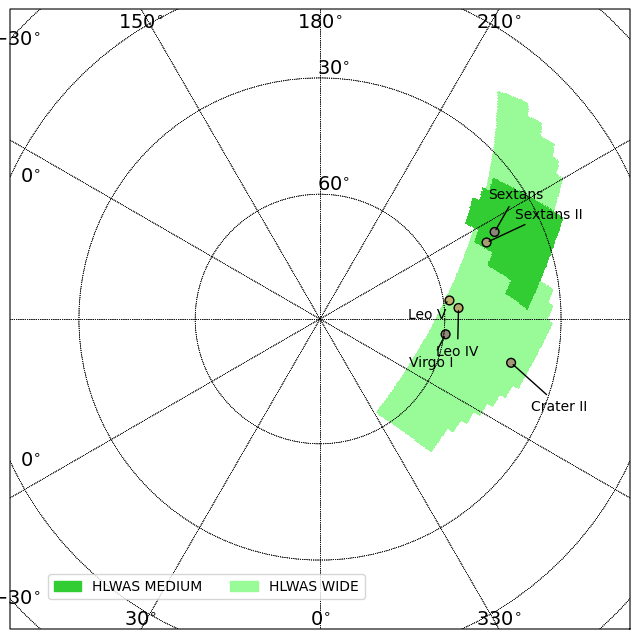

In [111]:
fig_gal_N = plot_polar_projection(combined_map,nbglm,
                                           nbglm_in_hlwas_north,
                                           'N',
                                           glabels=nbglm['name'][nbglm_in_hlwas_north],cbar=False)
#fig_gal_N.subplots_adjust(left=0.2,bottom=0.2,top=0.8)
#fig_gal_N.tight_layout(pad=10)
fig_gal_N.savefig('../figures/sats_north.png',dpi=300)

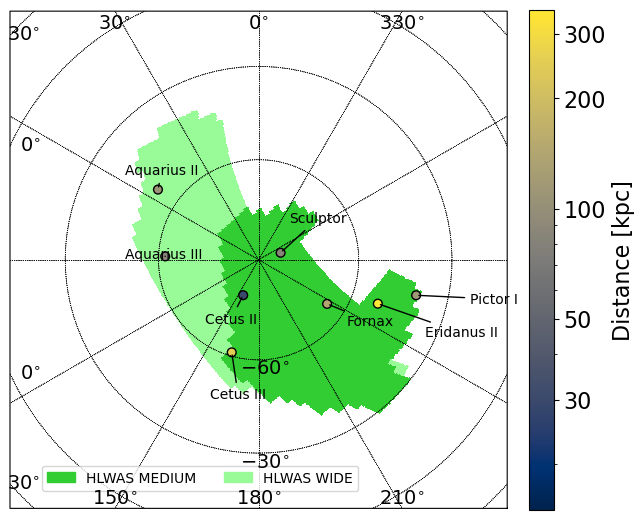

In [112]:
fig_sats_S = plot_polar_projection(combined_map, nbglm, nbglm_in_hlwas_south, 'S', nbglm['name'][nbglm_in_hlwas_south])
fig_sats_S.savefig('../figures/sats_south.png',dpi=300)

## two-panel plot

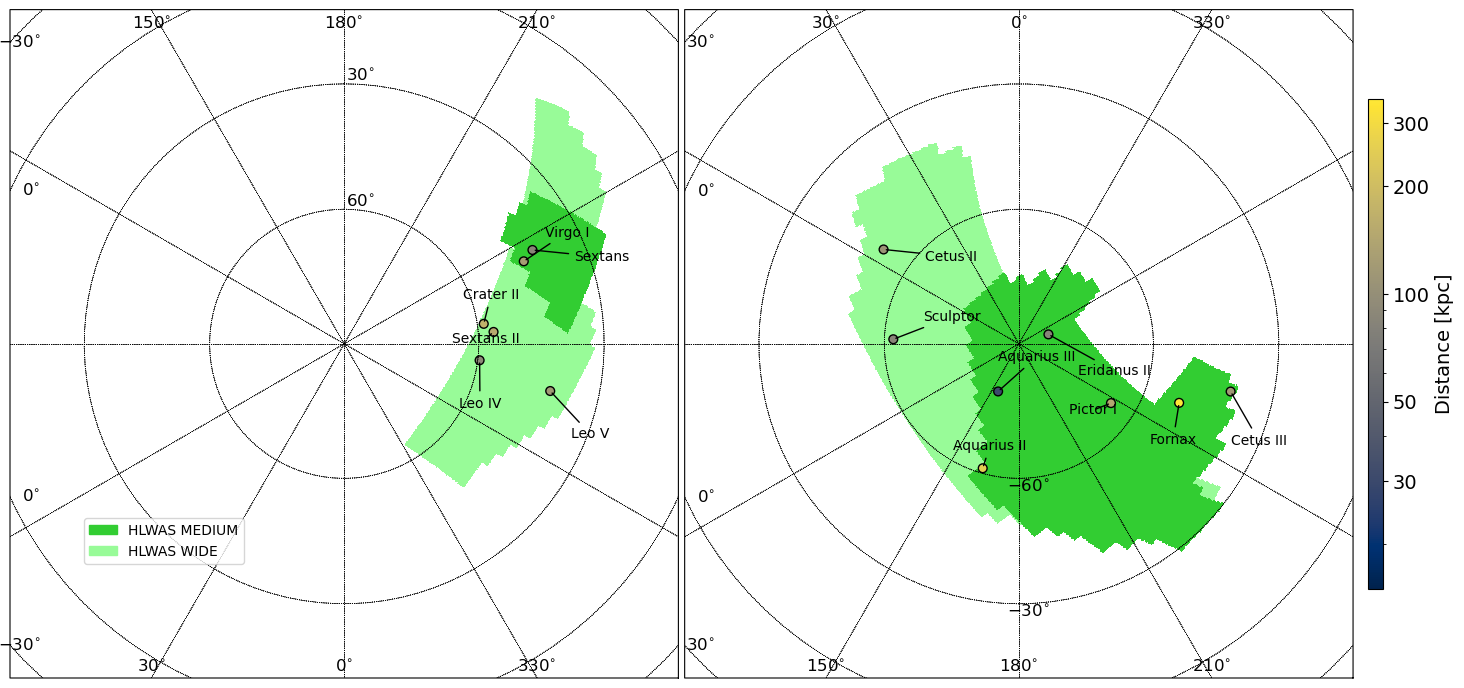

In [155]:
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib

fp = get_footprint()

# Design the color mapping
col_dict = {1: "palegreen", 
            2: "limegreen"}

# Create a colormap from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Make patches for the legend
patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')

# Define labels
labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM"])
len_lab = len(labels)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))


# south pole
sp_r = skyproj.LaeaSkyproj(ax=axs[1], lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])
im, _, _, _ = sp_r.draw_hpxmap(fp, lon_range=(0,360), lat_range=(-90, -10), vmin=1, vmax=3, cmap=cm, zoom=False)
cbh_r = plot_galaxies(sp_r,nbglm, glist=nbglm_in_hlwas_south,annotate=True,glabels=nbglm['name'][nbglm_in_hlwas_south])


#north pole
sp_l = skyproj.LaeaSkyproj(ax=axs[0], lat_0=90.0, galactic=True, extent=[0,360, 10,90])
im, _, _, _ = sp_l.draw_hpxmap(fp, lon_range=(0,360), lat_range=(10,90), vmin=1, vmax=3, cmap=cm, zoom=False)
cbh_l = plot_galaxies(sp_l,nbglm, glist=nbglm_in_hlwas_north,annotate=True,glabels=nbglm['name'][nbglm_in_hlwas_north])


#legends, colorbars and formatting
shandles=[patch_HLWAS_m,patch_HLWAS_w]
handles, labels = sp_l.ax.get_legend_handles_labels()
shandles.extend(handles)

sp_l.legend(handles=shandles, loc='upper left', ncol=1,  fontsize=10, bbox_to_anchor=(0.1,0.15, 0.5, 0.1))

sp_l.ax.tick_params(axis="x", labelsize=12, direction='in', pad=-15)
sp_l.ax.tick_params(axis="y", labelsize=12, direction='in', pad=-22)
sp_r.ax.tick_params(axis="x", labelsize=12, direction='in', pad=-15)
sp_r.ax.tick_params(axis="y", labelsize=12, direction='in', pad=-22)

fig.tight_layout(pad=0.5)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cb=plt.colorbar(cbh_r, cax = cbar_ax,
                ticks=[30,50,100,200,300],
                format=mticker.FixedFormatter(['30', '50', '100', '200', '300']))
#cb.set_ticks([],minor=True)
cb.set_label(label='Distance [kpc]', size=14)
#cb.set_label(label='Distance (Mpc)', size=16)
cb.ax.tick_params(labelsize=14)
fig.savefig('../figures/sats_poles.png',dpi=300)

## print table of info about galaxies in latex

In [21]:
ras=nbglm['ra'].values*u.deg
decs=nbglm['dec'].values*u.deg
nbg_coords=astropy.coordinates.SkyCoord(ras,decs)

In [22]:
idist=np.argsort(nbglm['distance'].values)

In [23]:
nbg_coords = nbg_coords[idist]

In [24]:

combined_map=get_footprint()
labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM"])

for i,sat in enumerate(nbg_coords):
    ipix = hp.ang2pix(hp.get_nside(combined_map),sat.galactic.l.value, sat.galactic.b.value,lonlat=True)
    if not combined_map[ipix]==hp.UNSEEN:
        which_s = labels[int(combined_map[ipix])-1][6:].lower()
        if sat.galactic.b.value > 0: 
            which_s += ' N'
        else:
            which_s += ' S'
        out = nbglm['name'][i]+' & '
        out += '{0:=02.0f} {1:=02.0f} {2:=02.1f}'.format(nbg_coords[i].ra.hms.h,nbg_coords[i].ra.hms.m,nbg_coords[i].ra.hms.s) 
        out += ' & '
        out += '{0:+d} {1:=02.0f} {2:=02.1f}'.format(int(nbg_coords[i].dec.dms.d),np.abs(nbg_coords[i].dec.dms.m),np.abs(nbg_coords[i].dec.dms.s))
        out += ' & '
        # lat = nbg_coords[i].galactic.l.wrap_at(180*u.deg)
        # out += '{0:+03d} {1:=02.0f} {2:=02.1f}'.format(int(lat.dms.d),np.abs(lat.dms.m),np.abs(lat.dms.s))
        # out += ' & '
        # out += '{0:+03d} {1:=02.0f} {2:=02.1f}'.format(int(nbg_coords[i].galactic.b.dms.d),np.abs(nbg_coords[i].galactic.b.dms.m),np.abs(nbg_coords[i].galactic.b.dms.s))
        # out += ' & '
        out += '{0:0.1f}'.format(nbglm['M_V'][i])
        out += ' & '
        out += '{0:0.3f}'.format(nbglm['distance'][i]/1000.)
        out += ' & '
        out += '{0:0.1f}'.format(nbglm['apparent_magnitude_v'][i])
        out += ' & ' + which_s
        out += ' \\\\'
        print(out)

Cetus II & 01 17 52.8 & -17 25 12.0 & 0.0 & 0.030 & 17.4 & medium S \\
Sculptor & 01 00 4.4 & -33 43 7.0 & -10.8 & 0.084 & 8.8 & medium S \\
Aquarius III & 23 48 52.3 & -3 29 20.4 & -2.5 & 0.086 & 17.2 & wide S \\
Sextans & 10 13 4.3 & -1 37 12.0 & -8.7 & 0.086 & 10.9 & medium N \\
Virgo I & 12 00 9.1 & +0 40 51.6 & -0.9 & 0.091 & 18.9 & wide N \\
Aquarius II & 22 33 55.5 & -9 19 38.6 & -4.4 & 0.108 & 15.8 & wide S \\
Pictor I & 04 43 47.4 & -50 16 59.0 & -3.1 & 0.115 & 17.2 & medium S \\
Crater II & 11 49 14.4 & -18 24 46.8 & -8.2 & 0.117 & 12.2 & wide N \\
Sextans II & 10 25 44.9 & +0 37 51.6 & -3.9 & 0.126 & 16.6 & medium N \\
Fornax & 02 39 50.0 & -34 29 58.9 & -13.4 & 0.143 & 7.4 & medium S \\
Leo IV & 11 32 57.7 & +0 32 43.1 & -5.0 & 0.151 & 15.9 & wide N \\
Leo V & 11 31 8.6 & +2 13 9.8 & -4.4 & 0.169 & 16.7 & wide N \\
Cetus III & 02 05 19.4 & -4 16 12.0 & -3.5 & 0.251 & 18.6 & medium S \\
Eridanus II & 03 44 22.2 & -43 31 58.4 & -7.1 & 0.370 & 15.7 & medium S \\


## all-sky plot

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib
# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict = {1: "palegreen", # "lightskyblue",
            2: "limegreen", # "dodgerblue",
            3: "firebrick"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM", "GPS"])
len_lab = len(labels)

In [ ]:
# read in healpix Gaia map
filename = DATA_DIR / 'gaia_stellar_density_map_G_21_gal_nside_128_v0.fits'
gaiamap = hp.read_map(filename)
gaiamap = change_coord(gaiamap, ['G', 'C'])
gaiamap -= np.min(gaiamap)
scale = np.std(gaiamap)*0.2
scaled_gmap = np.arcsinh(gaiamap/scale)

combined_map=get_footprint(coords='C')
#combined_map=change_coord(combined_map, ['G', 'C'])

alph=1.0

fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
sp = skyproj.sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90],  longitude_ticks='symmetric',galactic=False)
sp.draw_hpxmap(scaled_gmap,alpha=0.9,cmap='gray_r',vmin=0.5,vmax=5.0)


im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

# Add coordinates for GTBDS and HLTDS
gbtds_one = astropy.coordinates.SkyCoord('17h50m16.8700s', '-28d41m11.10s')
gbtds_two = astropy.coordinates.SkyCoord('17h49m53.4700s','-28d49m31.00s')
elais_n1 = astropy.coordinates.SkyCoord('16h10m1.0000s', '+54d30m36.00s')
euclid_s_wide = astropy.coordinates.SkyCoord('04h14m24.0000s', '-47d36m0.00s')
euclid_s_deep = astropy.coordinates.SkyCoord('03h55m36.0000s', '-49d19m12.00s')
hlwas_cosmos = astropy.coordinates.SkyCoord('10h00m24.0000s', '+02d10m55.00s')
hlwas_xmm = astropy.coordinates.SkyCoord('02h22m50.0000s', '-04d45m0.00s')


# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
#sp.circle(gbtds_one.ra.value, gbtds_one.dec.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
#HLTDS
sp.circle(elais_n1.ra.value, elais_n1.dec.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.ra.value, euclid_s_wide.dec.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.ra.value, euclid_s_deep.dec.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
#HLWAS DEEP
sp.circle(hlwas_cosmos.ra.value, hlwas_cosmos.dec.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.ra.value, hlwas_xmm.dec.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)

cbh = plot_galaxies(sp,gals=nbglm,radec=True)

#make legend

patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')


handles, labels = sp.ax.get_legend_handles_labels()
#handles.extend([patch_HLWAS_w, patch_HLWAS_m, patch_GPS])
shandles = handles[0:5]
shandles.extend([patch_HLWAS_m,patch_HLWAS_w])
shandles.extend([patch_GPS])
shandles.extend(handles[5:])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

#sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0, -0.35, 1.0, 0.55), fontsize=12)

plt.colorbar(cbh)

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)

plt.show();

In [157]:
0.1*1e-3 * 4.74 *100*1e3

47.400000000000006